In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

### Reweighting

An example of the training data, consisting of $N$ hadronization events (in the dataset below $N = 100,000$), is:
$$
\renewcommand\arraystretch{1.3}
  \boldsymbol{z} = \begin{pmatrix}
    \boldsymbol{z}_1 = \begin{pmatrix} \big\{ z^{h_1}_{\text{accept}}, z^{1, h_1}_{\text{reject}}, z^{2, h_1}_{\text{reject}}, \cdots, 									  z^{n_{h_1}, h_1}_{\text{reject}}\big\} \\
    								   \big\{ z^{h_2}_{\text{accept}}, z^{1, h_2}_{\text{reject}}, z^{2, h_2}_{\text{reject}}, \cdots, z^{n_{h_2}, h_2}_{\text{reject}} \big\} \\	
    								   \big\{ z^{h_3}_{\text{accept}}, z^{1, h_3}_{\text{reject}}, z^{2, h_3}_{\text{reject}}, \cdots, z^{n_{h_3}, h_3}_{\text{reject}} \big\} \end{pmatrix}_1 \\ \\
    \boldsymbol{z}_2 = \begin{pmatrix} \big\{ z^{h_1}_{\text{accept}}, z^{1, h_1}_{\text{reject}}, z^{2, h_1}_{\text{reject}}, \cdots, 									  z^{n_{h_1}, h_1}_{\text{reject}}\big\} \\
    								   \vdots \\	
    								   \big\{ z^{h_4}_{\text{accept}}, z^{1, h_4}_{\text{reject}}, z^{2, h_4}_{\text{reject}}, \cdots, z^{n_{h_4}, h_4}_{\text{reject}} \big\} \end{pmatrix}_2 \\
    \vdots \\
    \boldsymbol{z}_N = \cdots
  \end{pmatrix}, \quad 
  \boldsymbol{y}_\text{sim} = \begin{pmatrix}
    \boldsymbol{y}_1 = N_{h,1} = 3\\
    \boldsymbol{y}_2 = N_{h,2} = 4 \\
    \vdots \\
    \boldsymbol{y}_N = N_{h,N} = 2
  \end{pmatrix}
$$
Note that each array $\boldsymbol{z}_i$ is zero-padded to a fixed length of size $50$ and each accept-reject array is zero-padded to a fixed length of size $100$ (the maximum number of rejections is 99).

In [2]:
# Load the accept-reject data
filename_accept_reject_monash = '/home/tonym/Code/tuning_data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
pgun_accept_reject_monash = np.load(filename_accept_reject_monash, mmap_mode = "r")

#filename_accept_reject_island = '/home/tonym/Code/tuning_data/pgun_qqbar_accept_reject_z_a_1.5_b_0.6_sigma_0.335_N_1e5.npy'
#pgun_accept_reject_island = np.load(filename_accept_reject_island, mmap_mode = "r")

#filename_accept_reject_monash_prime = '/home/tonym/Code/tuning_data/pgun_qqbar_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_1e5.npy'
#pgun_accept_reject_monash_prime = np.load(filename_accept_reject_monash_prime, mmap_mode = "r")

# Load the hadron data
filename_hadrons_monash = '/home/tonym/Code/tuning_data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
pgun_hadrons_monash = np.load(filename_hadrons_monash, mmap_mode="r")

#filename_hadrons_island = '/home/tonym/Code/tuning_data/pgun_qqbar_hadrons_a_1.5_b_0.6_sigma_0.335_N_1e5.npy'
#pgun_hadrons_island = np.load(filename_hadrons_island, mmap_mode="r")

filename_hadrons_monash_prime = '/home/tonym/Code/tuning_data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e5.npy'
pgun_hadrons_monash_prime = np.load(filename_hadrons_monash_prime, mmap_mode="r")

In [3]:
print("Accepted and rejected z data shape (Monash):", pgun_accept_reject_monash.shape)
print("Hadron data shape (Monash):", pgun_hadrons_monash.shape)

#print("Accepted and rejected z data shape (Island):", pgun_accept_reject_island.shape)
#print("Hadron data shape (island):", pgun_hadrons_island.shape)

#print("Accepted and rejected z data shape (Monash'):", pgun_accept_reject_monash_prime.shape)
#print("Hadron data shape (Monash'):", pgun_hadrons_monash_prime.shape)

Accepted and rejected z data shape (Monash): (100000, 50, 100)
Hadron data shape (Monash): (100000, 50, 5)


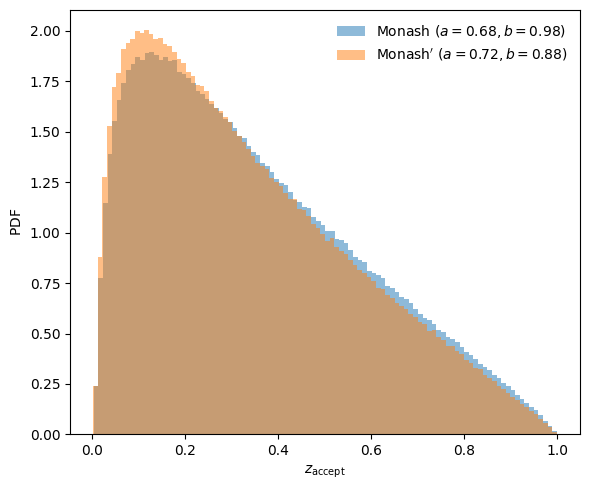

In [8]:
# Histrogram accepted z-values across all events
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.hist(pgun_accept_reject_monash[:,:,0][pgun_accept_reject_monash[:,:,0] > 0.0], 100, alpha = 0.5, density = True, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$')
#ax.hist(pgun_accept_reject_island[:,:,0][pgun_accept_reject_island[:,:,0] > 0.0], 100, alpha = 0.5, density = True, label = r"$\mathrm{'Island'}$ $(a = 1.5, b = 0.6)$")
ax.hist(pgun_accept_reject_monash_prime[:,:,0][pgun_accept_reject_monash_prime[:,:,0] > 0.0], 100, alpha = 0.5, density = True, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$")
ax.set_xlabel(r'$z_{\mathrm{accept}}$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

In [4]:
# Collect multiplicity data
mult_monash = np.array([len(pgun_hadrons_monash[i,:][np.abs(pgun_hadrons_monash[i,:,0]) > 0.0]) for i in range(pgun_hadrons_monash.shape[0])])
#mult_island = np.array([len(pgun_hadrons_island[i,:][pgun_hadrons_island[i,:,0] > 0.0]) for i in range(pgun_hadrons_island.shape[0])])
mult_monash_prime = np.array([len(pgun_hadrons_monash_prime[i,:][np.abs(pgun_hadrons_monash_prime[i,:,0]) > 0.0]) for i in range(pgun_hadrons_monash_prime.shape[0])])

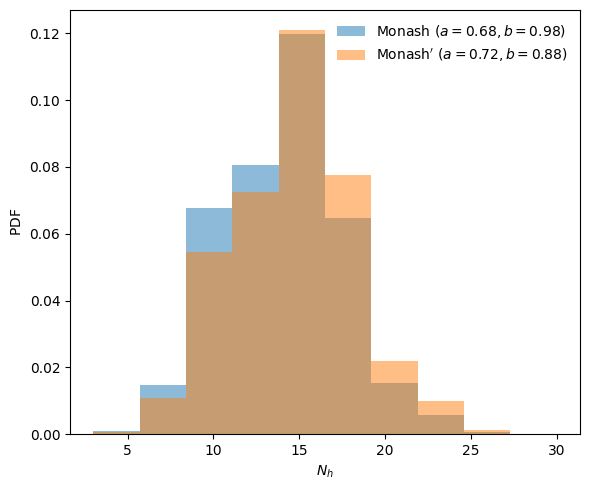

In [5]:
# Histrogram hadron multiplicity
fig, ax = plt.subplots(1,1,figsize=(6,5))
_, bins, _ = ax.hist(mult_monash, alpha = 0.5, density = True, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$')
ax.hist(mult_monash_prime, bins = bins, alpha = 0.5, density = True, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$")
#ax.hist(mult_island, bins = bins, alpha = 0.5, density = True, label = r"$\mathrm{'Island'}$ $(a = 1.5, b = 0.6)$")
ax.set_xlabel(r'$N_h$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

The reweighting module computes a weight array, given the base $B$ and perturbed $P$ parameterizations, according to 
$$
\boldsymbol{w} = \begin{pmatrix}
    w_1 \\
    w_2 \\
    \vdots \\
    w_N
  \end{pmatrix}, \text{ where } \\
  w_n = \prod_{i = 1}^{N_{h,n}} \left(\frac{f(z^{h_i}_\text{accept}; \{a, b\}_P)}{f(z^{h_i}_\text{accept}; \{a, b\}_{B})}\right)
  \prod_{j = 1}^{n_{h_i}} \left(\frac{\hat{f} - f(z^{j, h_i}_\text{reject}; \{a, b\}_P)}{\hat{f} - f(z^{j, h_i}_\text{reject}; \{a, b\}_{B}}\right)
$$
where $\hat{f}$ is the oversampling factor associated with the sampling of $z$ (here the over-sampling factor is 10). For each event, the accepcted and rejected $z$-values as well as the transverse mass $m_T^2 = p_x^2 + p_y^2 + m^2$ of each hadron is required to compute the event weight.

In [6]:
# The reweighting module
class Reweighter(nn.Module):
    def __init__(self, params_base, params, over_sample_factor = 10.):
        super(Reweighter, self).__init__()
        self.params_base = params_base
        self.params_a = torch.nn.Parameter(params[0].clone(), requires_grad=False) # Set required_grad = False for efficiency (needed for tuning)
        self.params_b = torch.nn.Parameter(params[1].clone(), requires_grad=False) # Set required_grad = False for efficiency (needed for tuning)
        self.over_sample_factor = over_sample_factor
    
    def zMaxCalc(self, a, b, c):
        # Superfluous constants
        AFROMZERO = 0.02
        AFROMC = 0.01
        
        # Normalization for Lund fragmentation function so that f <= 1.
        # Special cases for a = 0 and a = c.
        aIsZero = (a < AFROMZERO)
        aIsC = (torch.abs(a - c) < AFROMC)
        # Determine position of maximum.
        if aIsZero:
            return b / c if c > b else 1.
        elif aIsC:
            return b / (b + c)
        else:
            zMax = 0.5 * (b + c - torch.sqrt((b - c)**2 + 4 * a * b)) / (c - a)
            # Grab indicies for special condition
            # Assuming zMax, a, and b are PyTorch tensors of the same shape
            zMax = torch.where((zMax > 0.9999) & (b > 100.), torch.min(zMax, 1. - a / b), zMax)
            return zMax
    
    def likelihood(self, z, mT, a, b, c = torch.tensor(1.)):
        """
        Compute the likelihood of the Lund fragmentation function.
        """
        CFROMUNITY = 0.01
        AFROMZERO = 0.02
        AFROMC = 0.01
        EXPMAX = 50
        b_exp = b * torch.pow(mT, 2)
        # Special cases for c = 1, a = 0 and a = c.
        cIsUnity = (abs(c - 1.) < CFROMUNITY)
        aIsZero = (a < AFROMZERO)
        aIsC = (abs(a - c) < AFROMC)
        # Determine position of maximum.
        zMax = self.zMaxCalc(a, b_exp, c)
        aCoef = torch.log((1. - z) / (1. - zMax))
        bCoef = (1. / zMax - 1. / z)
        cCoef = torch.log(zMax / z)
        fExp = b_exp * bCoef + c * cCoef
        if not aIsZero:
            fExp += a * aCoef
        fVal = torch.exp(torch.clamp(fExp, min=-EXPMAX, max=EXPMAX))
        return fVal

    def forward(self, z, mT, observable):
        """
        Forward pass of the weight module -- consists of computing the event weights for a given batch
        of training data.
        """
        batch_size = z.shape[0]
        weights = torch.ones(batch_size)
    
        # Vectorizing the processing as much as possible (still room for improvement)
        for i in range(batch_size):
            # Multiplicity of event in batch
            event_mult = int(observable[i, 0])
            # Process accepted values
            accept_indices = z[i, :event_mult, 0] != 0.
            accept_tensor = z[i, :event_mult, 0][accept_indices]
            accept_mT = mT[i, :event_mult][accept_indices]
            accept_weights = self.likelihood(accept_tensor, accept_mT, self.params_a, self.params_b) / self.likelihood(accept_tensor, accept_mT, self.params_base[0], self.params_base[1])
            
            # Process rejected values
            reject_tensor = z[i, :event_mult, 1:]
            reject_weights = torch.ones(event_mult)
            for j in range(event_mult):
                reject_values = reject_tensor[j, reject_tensor[j, :] != 0.]
                if reject_values.numel() > 0:
                    reject_weights_i = (self.over_sample_factor - self.likelihood(reject_values, mT[i, j], self.params_a, self.params_b)) / (self.over_sample_factor - self.likelihood(reject_values, mT[i, j], self.params_base[0], self.params_base[1]))
                    reject_weights[j] = torch.prod(reject_weights_i)
    
            # Compute event weight
            event_weight = torch.prod(accept_weights) * torch.prod(reject_weights)
            weights[i] = event_weight
    
        return weights

In [7]:
# Define a new transverse mass array
#pgun_mT_island  = np.sqrt(pgun_hadrons_island[:, :, 0]**2 + pgun_hadrons_island[:, :, 1]**2 + pgun_hadrons_island[:, :, 4]**2)
pgun_mT_monash  = np.sqrt(pgun_hadrons_monash[:, :, 0]**2 + pgun_hadrons_monash[:, :, 1]**2 + pgun_hadrons_monash[:, :, 4]**2)

In [8]:
# Set base parameterization
params_base = torch.tensor([0.68, 0.98]) # (a,b)

# Set parameters to rewieigh to
params_target = torch.tensor([0.72, 0.88]) # Monash'

# Set the over sample factor (for the pgun_qqbar datasets this is 10.)
over_sample_factor = 10.

# Initialize the reweighting module
reweighter = Reweighter(params_base, params_target, over_sample_factor=over_sample_factor)

In [9]:
# Consider a 'batch' consisting of 50,000 events
nevents = 50000
# Convert the numpy arrays to torch tensors
pgun_accept_reject_monash_torch = torch.from_numpy(pgun_accept_reject_monash[0:nevents].copy())
pgun_mT_monash_torch = torch.from_numpy(pgun_mT_monash[0:nevents].copy())
pgun_mult_monash_torch = torch.from_numpy(mult_monash[0:nevents].copy())
pgun_mult_monash_torch = torch.reshape(pgun_mult_monash_torch, (nevents,1))

In [10]:
# Check the shapes
print(pgun_mT_monash_torch.shape)
print(pgun_accept_reject_monash_torch.shape)
print(pgun_mult_monash_torch.shape)

torch.Size([50000, 50])
torch.Size([50000, 50, 100])
torch.Size([50000, 1])


In [11]:
# Compute the weight array
weights = reweighter.forward(pgun_accept_reject_monash_torch, pgun_mT_monash_torch, pgun_mult_monash_torch)

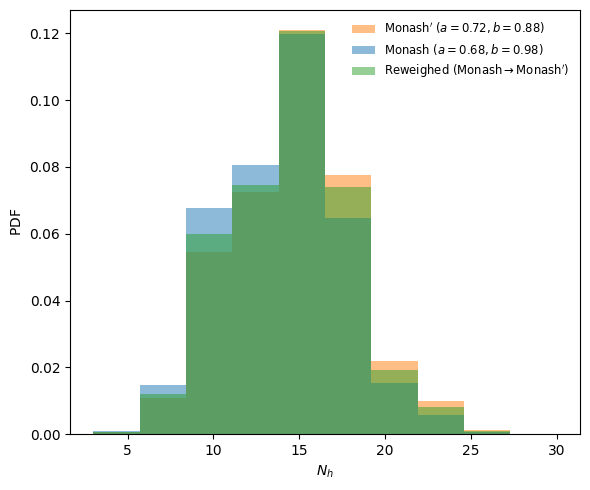

In [12]:
# Histrogram hadron multiplicity
fig, ax = plt.subplots(1,1,figsize=(6,5))
_, bins, _ = ax.hist(mult_monash_prime, bins = bins, alpha = 0.5, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$", color = 'tab:orange', density = True)
ax.hist(mult_monash, bins = bins, alpha = 0.5, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$', color = 'tab:blue', density = True)
ax.hist(pgun_mult_monash_torch.detach().numpy(), bins = bins, weights = weights.detach().numpy(), alpha = 0.5, label = r"$\mathrm{Reweighed}$ $(\mathrm{Monash} \rightarrow \mathrm{Monash}')$", color = 'tab:green', density = True)
ax.set_xlabel(r'$N_h$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False, fontsize = 'small')
fig.tight_layout()

### Data structure

In [14]:
# Accept-reject dataset
print('Event-level accepted and rejected z-value array:')
print(pgun_accept_reject_monash[0]) # Event (zero-padded to a fixed length of 50)
print()
print('Accepted and rejected z-values for first hadron:')
print(pgun_accept_reject_monash[0,0]) # Accepted and rejected z-values for first hadron
print()
print('First hadron accepted z-value:')
print(pgun_accept_reject_monash[0,0,0]) # Accepted z-value
print()
print('First hadron rejected z-values (zero-padded to a fixed length of 50):')
print(pgun_accept_reject_monash[0,0,1:]) # Rejected z-values (zero-padded to a fixed lenght of 50)
print()
# Hadron dataset
print('Event-level hadron data array:')
print(pgun_hadrons_monash[0]) # Event (zero-padded to a fixed length of 50)
print()
print('(p_x, p_y, p_z, E, m_h) of first hadron:')
print(pgun_hadrons_monash[0,0]) # First hadron (p_x, p_y, p_z, E, m_h)

Event-level accepted and rejected z-value array:
[[0.0686964 0.874901  0.920626  ... 0.        0.        0.       ]
 [0.395404  0.359597  0.32135   ... 0.        0.        0.       ]
 [0.322769  0.742624  0.116491  ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]

Accepted and rejected z-values for first hadron:
[0.0686964 0.874901  0.920626  0.227735  0.254977  0.106352  0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.  